# Exploration pour la prédiction des jours Tempo

### Rappel des règles données par RTE pour le placement des jours Tempo: 
- Une année « Tempo » s’étend du 1er septembre d’une année au 31 août de l’année suivante
- Une année Tempo comprend 22 jours rouges et 43 jours blancs
- les jours rouges sont tirés entre le 1er novembre et le 31 mars,
- les jours rouges ne peuvent être tirés le weekend,
- un maximum de 5 jours rouges consécutifs peut être tiré,
- les jours blancs peuvent être tirés toute l’année, sauf le dimanche. 

Source : [Méthode de choix des jours Tempo - Fiche explicative de l’algorithme utilisé par RTE](https://www.services-rte.com/files/live/sites/services-rte/files/pdf/20160106_Methode_de_choix_des_jours_Tempo.pdf)

### Hypothèse / affirmation :  
La production d'éolien et de solaire varie mais est la première brique du mix électrique français. S'ajoute à cette première brique la production du nucléaire, plus grosse base nationale, peu pilotable sur les fluctuations rapides du réseau. Puis viennent charbon et gaz naturel, ce dernier étant le plus pratique pour gérer les fluctuations. 

### Notes :
- Ajouter trois colonnes 'stock_j_blanc', 'stock_j_bleu', 'stock_j_rouge' qui comptent le nombre de jours en stock à J0. Il faut donc prévoir une remise à zéro chaque année.  
=> On pourrait penser que deux colonnes sont suffisantes, mais je pense que le stock de jours bleus peut aussi permettre au modèle de se placer sur le nombre de jours restants sur "l'année Tempo"  
=> Reset les jours chaque année le 1er septembre  <span style="color:green">**Fait**</span>  
- Comment gérer les données manquantes ? On a les données de vent & flux solaire seulement depuis Février 2022.  
=> On peut filtrer sur ces dates là à priori car RTE calcul sur un an glissant à chaque fois <span style="color:green">**Fait**</span>  
- Comment faire comprendre au modèle qu'il ne peut pas prédire un jour rouge dans certain cas ?
=> Ajouter un booléen pour signifier si le jour peut être rouge ou non ?
=> Est-il possible de donner le choix uniquement entre jours blancs et jour bleus les jours quand on est en dehors des conditions pour les jours rouges ?
=> Ou alors encore plus simple : si un jour rouge est prédit, mais les conditions ne sont pas remplies = jour blanc (si stock restant), RTE bosse de cette manière. <span style="color:red">**A faire**</span>  
- Quelles colonnes garder pour le modèle ?
=> Les stocks de jour, la production à J-1, la consommation à J+1, la production ENR (ou flux solaire / vent) à J+1 <span style="color:red">**A faire**</span>  


In [20]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 400)

import os
from calendar import isleap


## Read data

In [21]:
in_relative_path = "../../../data/gold/"
in_absolute_path = os.path.abspath(os.path.join(os.getcwd(), in_relative_path))

data = pd.read_csv(f"{in_absolute_path}/rte_daily_2014_2024.csv")
data["Date"] = pd.to_datetime(data["Date"])


# Feature Engineering
### Ajout des colonnes de stocks restants des jours Tempo

In [30]:
stock_jours_annuels = {
    "rouge": 22,
    "blanc": 43,
    "bleu": 300
}
stock_jours_annuels_b = {
    "rouge": 22,
    "blanc": 43,
    "bleu": 301
}

def get_base_stock(year:int) -> dict:
    """
    Vérifie si l'année est bissextiles ou non
    Renvoie le stock initial de jour tempo.

    :param year: _description_
    :return: _description_
    """
    if isleap(year):
        nb_days = 366
        return stock_jours_annuels_b.copy(), nb_days
    else:
        nb_days = 365
        return stock_jours_annuels.copy(), nb_days
    
def update_stock(previous_tempo:str, stock_actuel:dict) -> dict:
    if previous_tempo:
        if previous_tempo == "ROUGE":
            stock_actuel["rouge"] -= 1
        elif previous_tempo == "BLANC":
            stock_actuel["blanc"] -= 1
        elif previous_tempo == "BLEU":
            stock_actuel["bleu"] -= 1
        return stock_actuel
    else:
        return None
    
def check_stock_empty(stock_actuel:dict, year:int):
    """
    Cette fonction permet de vérifier si les stocks sont bien calculés :
    Tout les stocks doivent à 0, si ce n'est pas le cas c'est que RTE
    n'a pas utilisé tout les jours en stock, l'écart devrait alors se 
    répercuter négativement sur les jours bleus (la somme du dictionnaire doit être de 0 forcément)

    :param stock_actuel: _description_
    :param year: _description_
    """
    if stock_actuel:
        if stock_actuel["rouge"] == stock_actuel["bleu"] == stock_actuel["blanc"] == 0:
            pass
        else:
            print(f"Les stocks de jours n'était pas à 0 le 1er septembre {year} ! :(")
            print(f"Voici l'état du stock : {stock_actuel}")
            if stock_actuel["rouge"] + stock_actuel["bleu"] + stock_actuel["blanc"] != 0:
                raise ValueError("La somme des stocks ne fait pas 0 à la fin de l'année.")


def get_cumulative_stock(data):
    """
    On calcule les stocks restants pour chaque jour tempo à une date X.

    Les valeurs représentent la situation à J-1 car la prédiction
    pour une date D se fait avec le stocks restants à J-1.

    Ex : 
    Une row avec 
        - stock_j_rouge = 0
        - stock_j_blanc = 1
        - stock_j_bleu = 14
        - type_tempo = "BLANC"
    => Au moment de prédire le jour "BLANC", je n'avais plus de jour rouge
    mais il me restait un dernier jour blanc en stock

    :param data: _description_
    :return: _description_
    """
    stock_rouge, stock_bleu, stock_blanc, jour_tempo = [], [], [], []
    previous_tempo = stock_actuel = None
    for i, row in data.iterrows():
        year = row["Date"].year
        # Remise à zéro les 1er Septembre
        # sinon on update le stock en fonction du type tempo de la veille 
        if row["Date"].month == 9 and row["Date"].day == 1:
            update_stock(previous_tempo, stock_actuel)
            check_stock_empty(stock_actuel, year)
            stock_actuel, nb_days = get_base_stock(year + 1)
            jour_tempo.extend(list(range(nb_days)))
        else:
            update_stock(previous_tempo, stock_actuel)
        
        stock_rouge.append(stock_actuel["rouge"])
        stock_blanc.append(stock_actuel["blanc"])
        stock_bleu.append(stock_actuel["bleu"])

        # On enregistre le type tempo
        previous_tempo = row["type_tempo"]
    
    data["stock_j_rouge"] = stock_rouge
    data["stock_j_blanc"] = stock_blanc
    data["stock_j_bleu"] = stock_bleu
    data["jour_tempo"] = jour_tempo[:len(stock_rouge)]

    return data

data = get_cumulative_stock(data)

Les stocks de jours n'était pas à 0 le 1er septembre 2020 ! :(
Voici l'état du stock : {'rouge': 4, 'blanc': -4, 'bleu': 0}
Les stocks de jours n'était pas à 0 le 1er septembre 2022 ! :(
Voici l'état du stock : {'rouge': 0, 'blanc': 1, 'bleu': -1}


In [31]:
data

,Date,Nature,type_tempo,Consommation,Prévision_J-1,Prévision_J,Fioul,Charbon,Gaz,Nucléaire,...,Bioénergies,Ech_physiques,Taux_de_Co2,Ech_comm,sun,wind,stock_j_rouge,stock_j_blanc,stock_j_bleu,jour_tempo
0,2014-09-01,Données définitives,BLEU,549696.750,549675.00,545475.0,2805.250,9435.00,9114.000,543040.750,...,9441.250,-112329.500,414.500,-108445.000,NaN,NaN,22,43,300,0
1,2014-09-02,Données définitives,BLEU,570301.750,565500.00,568350.0,2823.000,12168.00,8396.000,549099.500,...,9605.000,-98869.750,459.000,-94835.000,NaN,NaN,22,43,299,1
2,2014-09-03,Données définitives,BLEU,572659.250,567700.00,563650.0,2793.000,9495.75,6157.250,547309.000,...,9544.750,-96163.000,398.250,-92401.500,NaN,NaN,22,43,298,2
3,2014-09-04,Données définitives,BLEU,576923.000,564675.00,569800.0,2871.000,10461.75,6895.250,543333.750,...,9539.500,-81769.500,428.000,-78653.500,NaN,NaN,22,43,297,3
4,2014-09-05,Données définitives,BLEU,572880.250,566525.00,569950.0,2761.500,10675.50,7781.500,550745.250,...,9491.250,-87388.500,431.500,-84271.000,NaN,NaN,22,43,296,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3504,2024-04-05,Données temps réel,BLEU,556538.000,561437.50,550637.5,1499.000,0.00,7277.250,407607.375,...,9543.000,-101724.500,160.375,-49060.250,1.423090e+07,4.879554,0,8,141,217
3505,2024-04-06,Données temps réel,BLEU,485519.875,478718.75,486987.5,1498.000,0.00,7017.750,324737.250,...,9473.625,-77274.750,183.875,-38609.625,1.757204e+07,5.793304,0,8,140,218
3506,2024-04-07,Données temps réel,BLEU,464582.375,465193.75,465375.0,1633.375,0.00,7946.625,308369.250,...,9422.625,-26822.250,223.250,-13769.250,1.166932e+07,3.579645,0,8,139,219
3507,2024-04-08,Données temps réel,BLEU,290497.750,544651.00,544925.0,821.500,0.00,4534.875,243594.250,...,5255.625,-56747.375,97.250,-51114.125,1.391853e+07,4.507709,0,8,138,220


# Filtre sur les dernières données
### On garde uniquement les données avec des valeurs de vent & flux solaire

In [4]:
data = data[data["Date"] >= "2022-02-01"].reset_index(drop=True)

# Modèles
### A.  Nucléaire, flux solaire et vent
- Consommation de J
- Production nucléaire de J-1
- Prévision "sun" de J
- Prévision "wind" de J 

In [5]:
def modele_a_transform(data:pd.DataFrame):
    data['Nucléaire_J-1'] = data['Nucléaire'].shift(1)

    columns_to_keep = [
        "Date",
        "Consommation",
        "Nucléaire",
        "Nucléaire_J-1",
        "sun",
        "wind",
        "stock_j_rouge",
        "stock_j_blanc",
        "stock_j_bleu",
        "type_tempo",
    ]
    data = data[columns_to_keep]
    return data

data_a = modele_a_transform(data)
data_a



,Date,Consommation,Nucléaire,Nucléaire_J-1,sun,wind,stock_j_rouge,stock_j_blanc,stock_j_bleu,type_tempo
0,2022-02-01,860492.500,571452.750,NaN,3.901272e+06,4.906875,0,22,190,BLEU
1,2022-02-02,805681.500,573210.000,571452.750,4.494408e+06,3.661905,0,22,189,BLANC
2,2022-02-03,809729.000,578999.250,573210.000,4.781211e+06,2.776255,0,21,189,BLANC
3,2022-02-04,796406.000,575861.750,578999.250,4.245190e+06,3.987258,0,20,189,BLEU
4,2022-02-05,743808.500,538712.500,575861.750,7.963900e+06,3.375999,0,20,188,BLEU
...,...,...,...,...,...,...,...,...,...,...
794,2024-04-05,556538.000,407607.375,433068.125,1.423090e+07,4.879554,0,8,141,BLEU
795,2024-04-06,485519.875,324737.250,407607.375,1.757204e+07,5.793304,0,8,140,BLEU
796,2024-04-07,464582.375,308369.250,324737.250,1.166932e+07,3.579645,0,8,139,BLEU
797,2024-04-08,290497.750,243594.250,308369.250,1.391853e+07,4.507709,0,8,138,BLEU


Précision du modèle: 91.67%


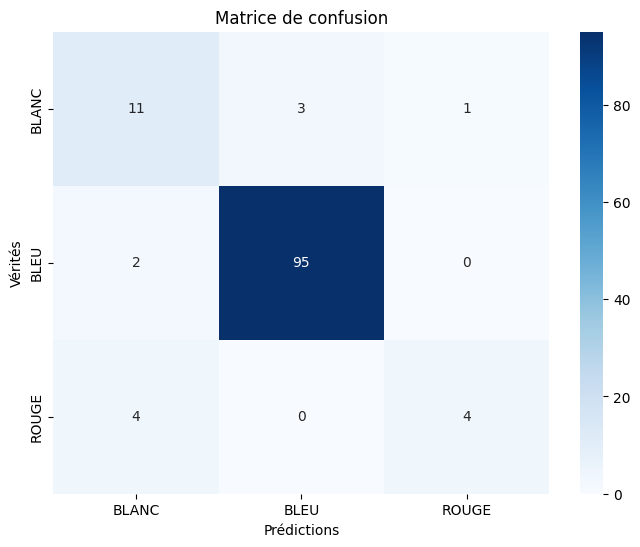

Rapport de classification :
               precision    recall  f1-score   support

       BLANC       0.65      0.73      0.69        15
        BLEU       0.97      0.98      0.97        97
       ROUGE       0.80      0.50      0.62         8

    accuracy                           0.92       120
   macro avg       0.81      0.74      0.76       120
weighted avg       0.92      0.92      0.91       120



In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que df soit votre DataFrame
# df = pd.read_csv('votre_fichier.csv')

df = data_a.copy()

# Encodage de la variable cible
label_encoder = LabelEncoder()
df['type_tempo'] = label_encoder.fit_transform(df['type_tempo'])

# Séparation des features et de la cible
X = df.drop(columns=['Date', 'type_tempo'])
y = df['type_tempo']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Préparation des datasets LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Définition des paramètres du modèle
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Entraînement du modèle
bst = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

# Prédictions sur les données de test
y_pred = bst.predict(X_test)
y_pred_max = np.argmax(y_pred, axis=1)

# Calcul de la précision
accuracy = accuracy_score(y_test, y_pred_max)
print(f'Précision du modèle: {accuracy * 100:.2f}%')

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_max)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de confusion')
plt.show()

# Rapport de classification
class_report = classification_report(y_test, y_pred_max, target_names=label_encoder.classes_)
print('Rapport de classification :\n', class_report)

### B.  Reprise de l'algorithme RTE
- Suivi des [règles RTE](https://www.services-rte.com/files/live/sites/services-rte/files/pdf/20160106_Methode_de_choix_des_jours_Tempo.pdf)

In [32]:
data.head()

,Date,Nature,type_tempo,Consommation,Prévision_J-1,Prévision_J,Fioul,Charbon,Gaz,Nucléaire,...,Bioénergies,Ech_physiques,Taux_de_Co2,Ech_comm,sun,wind,stock_j_rouge,stock_j_blanc,stock_j_bleu,jour_tempo
0,2014-09-01,Données définitives,BLEU,549696.75,549675.0,545475.0,2805.25,9435.00,9114.00,543040.75,...,9441.25,-112329.50,414.50,-108445.0,NaN,NaN,22,43,300,0
1,2014-09-02,Données définitives,BLEU,570301.75,565500.0,568350.0,2823.00,12168.00,8396.00,549099.50,...,9605.00,-98869.75,459.00,-94835.0,NaN,NaN,22,43,299,1
2,2014-09-03,Données définitives,BLEU,572659.25,567700.0,563650.0,2793.00,9495.75,6157.25,547309.00,...,9544.75,-96163.00,398.25,-92401.5,NaN,NaN,22,43,298,2
3,2014-09-04,Données définitives,BLEU,576923.00,564675.0,569800.0,2871.00,10461.75,6895.25,543333.75,...,9539.50,-81769.50,428.00,-78653.5,NaN,NaN,22,43,297,3
4,2014-09-05,Données définitives,BLEU,572880.25,566525.0,569950.0,2761.50,10675.50,7781.50,550745.25,...,9491.25,-87388.50,431.50,-84271.0,NaN,NaN,22,43,296,4


In [39]:
data.dtypes

Date                 datetime64[ns]
Nature                       object
type_tempo                   object
Consommation                float64
Prévision_J-1               float64
Prévision_J                 float64
Fioul                       float64
Charbon                     float64
Gaz                         float64
Nucléaire                   float64
Eolien                      float64
Solaire                     float64
Hydraulique                 float64
Pompage                     float64
Bioénergies                 float64
Ech_physiques               float64
Taux_de_Co2                 float64
Ech_comm                    float64
sun                         float64
wind                        float64
stock_j_rouge                 int64
stock_j_blanc                 int64
stock_j_bleu                  int64
jour_tempo                    int64
seuil_rouge                 float64
seuil_blanc_rouge           float64
dtype: object

In [48]:
data_b = data.copy()

data_b["production_nette"] = data_b["Prévision_J-1"] - (data_b["Eolien"] + data_b["Solaire"])  # here need to use Predicted production

q80 = data_b["production_nette"].quantile(0.8)
q40 = data_b["production_nette"].quantile(0.4)
qtemp30 = 8.5  # Rought estimation
gamma = -0.1176
kappa = 8.3042

data_b["production_norm"] = (data_b["production_nette"] - q40) / (   (q80 - q40) * np.exp(gamma * (kappa - qtemp30)) )  # there is a typo in the docs here : it is a - not a +

A_rouge = 3.15
B_rouge = -0.010
C_rouge = -0.031
A_blanc_rouge = 4
B_blanc_rouge = -0.015
C_blanc_rouge = -0.026

data_b["seuil_rouge"] = (
    A_rouge + B_rouge * data_b["jour_tempo"] + C_rouge * data_b["stock_j_rouge"]
)
data_b["seuil_blanc_rouge"] = (
    A_blanc_rouge
    + B_blanc_rouge * data_b["jour_tempo"]
    + C_blanc_rouge * (data_b["stock_j_rouge"] + data_b["stock_j_blanc"])
)

prediction_rouge = data_b["production_norm"] > data_b["seuil_rouge"]
# Faire un filtre sur une nouvelle colonne 'mois' directement
# start_ROUGE_allowed = "2015-10-31"
# end_ROUGE_allowed = "2016-04-01"
# prediction_rouge[:start_ROUGE_allowed] = False
# prediction_rouge[end_ROUGE_allowed:] = False
prediction_rouge[data_b["stock_j_rouge"] < 0] = False

sundays = data_b["Date"].dt.weekday == 6
saturdays = data_b["Date"].dt.weekday == 5
prediction_rouge[sundays] = False
prediction_rouge[saturdays] = False

prediction_blanc_rouge = data_b["production_norm"] > data_b["seuil_blanc_rouge"]
prediction_blanc = prediction_blanc_rouge & ~prediction_rouge
prediction_blanc[sundays] = False

prediction_blanc[data_b["stock_j_blanc"] < 0] = False

data_b["prediction_j_rouge"] = prediction_rouge
data_b["prediction_j_blanc"] = prediction_blanc
data_b["prediction_j_bleu"] = ~(data_b['prediction_j_rouge'] | data_b['prediction_j_blanc'])

In [49]:
data_b.head(20)

,Date,Nature,type_tempo,Consommation,Prévision_J-1,Prévision_J,Fioul,Charbon,Gaz,Nucléaire,...,stock_j_blanc,stock_j_bleu,jour_tempo,seuil_rouge,seuil_blanc_rouge,production_nette,production_norm,prediction_j_rouge,prediction_j_blanc,prediction_j_bleu
0,2014-09-01,Données définitives,BLEU,549696.75,549675.0,545475.0,2805.25,9435.00,9114.00,543040.75,...,43,300,0,2.468,2.310,525451.00,0.056248,False,False,True
1,2014-09-02,Données définitives,BLEU,570301.75,565500.0,568350.0,2823.00,12168.00,8396.00,549099.50,...,43,299,1,2.458,2.295,541430.25,0.144199,False,False,True
2,2014-09-03,Données définitives,BLEU,572659.25,567700.0,563650.0,2793.00,9495.75,6157.25,547309.00,...,43,298,2,2.448,2.280,534110.75,0.103912,False,False,True
3,2014-09-04,Données définitives,BLEU,576923.00,564675.0,569800.0,2871.00,10461.75,6895.25,543333.75,...,43,297,3,2.438,2.265,543332.25,0.154667,False,False,True
4,2014-09-05,Données définitives,BLEU,572880.25,566525.0,569950.0,2761.50,10675.50,7781.50,550745.25,...,43,296,4,2.428,2.250,552606.50,0.205713,False,False,True
5,2014-09-06,Données définitives,BLEU,503624.50,501300.0,502300.0,2816.75,1018.00,6418.25,532306.50,...,43,295,5,2.418,2.235,487929.25,-0.150272,False,False,True
6,2014-09-07,Données définitives,BLEU,469742.75,468250.0,467325.0,2816.00,0.00,6479.50,517577.75,...,43,294,6,2.408,2.220,452136.75,-0.347276,False,False,True
7,2014-09-08,Données définitives,BLEU,565318.50,565525.0,563475.0,2812.50,4258.50,9052.75,557656.25,...,43,293,7,2.398,2.205,546641.25,0.172880,False,False,True
8,2014-09-09,Données définitives,BLEU,580161.50,585950.0,577450.0,2824.75,11463.00,8886.75,564564.50,...,43,292,8,2.388,2.190,564948.25,0.273643,False,False,True
9,2014-09-10,Données définitives,BLEU,580898.00,578125.0,576625.0,2793.50,12752.50,9055.25,565357.25,...,43,291,9,2.378,2.175,547092.50,0.175364,False,False,True


In [50]:
data_b["is_pred_good"] = ((data_b['prediction_j_rouge'] & (data_b["type_tempo"] == 'ROUGE')) |
           (data_b['prediction_j_blanc'] & (data_b["type_tempo"] == 'BLANC')) |
           (data_b['prediction_j_bleu'] & (data_b["type_tempo"] == 'BLEU')))

,Date,Nature,type_tempo,Consommation,Prévision_J-1,Prévision_J,Fioul,Charbon,Gaz,Nucléaire,...,stock_j_bleu,jour_tempo,seuil_rouge,seuil_blanc_rouge,production_nette,production_norm,prediction_j_rouge,prediction_j_blanc,prediction_j_bleu,is_pred_good
0,2014-09-01,Données définitives,BLEU,549696.750,549675.00,545475.0,2805.250,9435.00,9114.000,543040.750,...,300,0,2.468,2.310,525451.000,0.056248,False,False,True,True
1,2014-09-02,Données définitives,BLEU,570301.750,565500.00,568350.0,2823.000,12168.00,8396.000,549099.500,...,299,1,2.458,2.295,541430.250,0.144199,False,False,True,True
2,2014-09-03,Données définitives,BLEU,572659.250,567700.00,563650.0,2793.000,9495.75,6157.250,547309.000,...,298,2,2.448,2.280,534110.750,0.103912,False,False,True,True
3,2014-09-04,Données définitives,BLEU,576923.000,564675.00,569800.0,2871.000,10461.75,6895.250,543333.750,...,297,3,2.438,2.265,543332.250,0.154667,False,False,True,True
4,2014-09-05,Données définitives,BLEU,572880.250,566525.00,569950.0,2761.500,10675.50,7781.500,550745.250,...,296,4,2.428,2.250,552606.500,0.205713,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3504,2024-04-05,Données temps réel,BLEU,556538.000,561437.50,550637.5,1499.000,0.00,7277.250,407607.375,...,141,217,0.980,0.537,409471.250,-0.582108,False,False,True,True
3505,2024-04-06,Données temps réel,BLEU,485519.875,478718.75,486987.5,1498.000,0.00,7017.750,324737.250,...,140,218,0.970,0.522,335182.125,-0.990997,False,False,True,True
3506,2024-04-07,Données temps réel,BLEU,464582.375,465193.75,465375.0,1633.375,0.00,7946.625,308369.250,...,139,219,0.960,0.507,372644.000,-0.784806,False,False,True,True
3507,2024-04-08,Données temps réel,BLEU,290497.750,544651.00,544925.0,821.500,0.00,4534.875,243594.250,...,138,220,0.950,0.492,502878.000,-0.067994,False,False,True,True


In [53]:
data_b["is_pred_good"].value_counts()

is_pred_good
True     2473
False    1036
Name: count, dtype: int64

In [54]:
data_b[["type_tempo", "prediction_j_rouge", "prediction_j_blanc", "prediction_j_bleu", "is_pred_good"]].head(10)

,type_tempo,prediction_j_rouge,prediction_j_blanc,prediction_j_bleu,is_pred_good
0,BLEU,False,False,True,True
1,BLEU,False,False,True,True
2,BLEU,False,False,True,True
3,BLEU,False,False,True,True
4,BLEU,False,False,True,True
5,BLEU,False,False,True,True
6,BLEU,False,False,True,True
7,BLEU,False,False,True,True
8,BLEU,False,False,True,True
9,BLEU,False,False,True,True


In [62]:
data_b["prediction_j_rouge"].to_csv("test.csv")

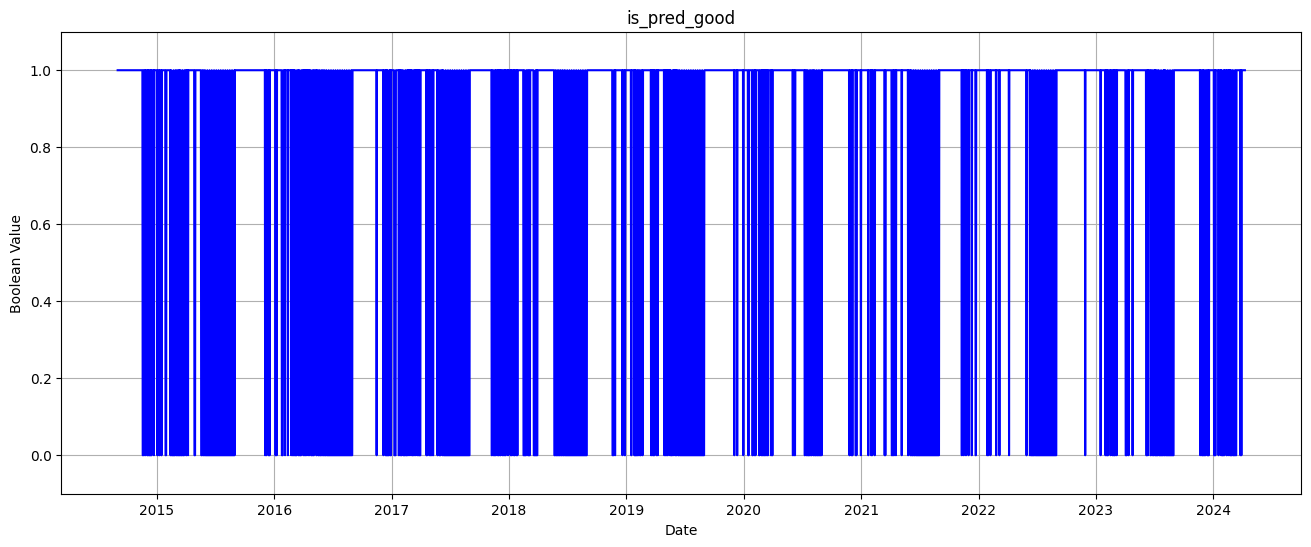

In [64]:
plt.figure(figsize=(16, 6))
plt.plot(data_b['Date'], data_b['is_pred_good'], linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Boolean Value')
plt.title('is_pred_good')
plt.ylim(-0.1, 1.1)  # Pour que les points booléens soient bien visibles
plt.grid(True)
plt.show()